# Multimodal RAG

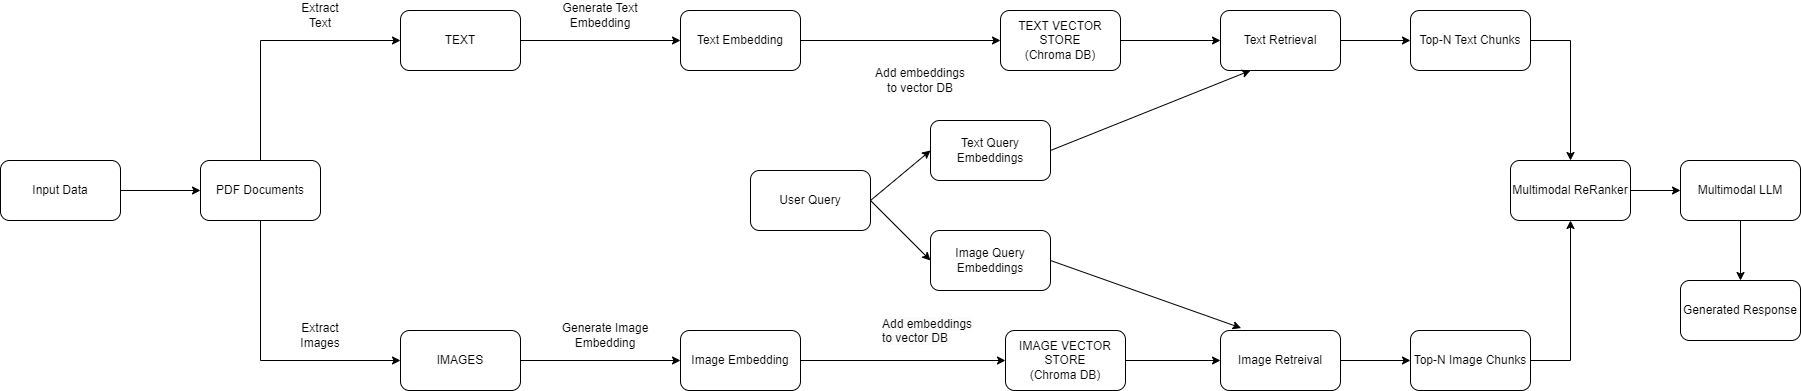

In [1]:
import os
import fitz  # PyMuPDF for reading PDFs
import torch
from transformers import CLIPProcessor, CLIPModel
from chromadb import Client
from langchain.schema import SystemMessage, HumanMessage  # Add this import
from PIL import Image
from io import BytesIO

In [2]:
# Initialize the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

c:\Users\ajayk\anaconda3\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
# Initialize Chroma client and create a collection
client = Client()
text_collection = client.get_or_create_collection(name="text_embeddings_collection")
image_collection = client.get_or_create_collection(name="image_embeddings_collection")


In [4]:
import os
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key)

c:\Users\ajayk\anaconda3\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [5]:
# Function to extract text from a PDF
def extract_text_from_pdf(pdf_path):
    text = ""
    doc = fitz.open(pdf_path)
    
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text += page.get_text("text")
    
    return text

In [6]:
# Function to generate text embeddings using CLIP and ensure they are converted to lists
def generate_text_embedding(text):
    chunks = [text[i:i + 512] for i in range(0, len(text), 512)]  # Split text into manageable chunks
    embeddings = []
    
    for chunk in chunks:
        inputs = processor(text=[chunk], return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            embedding = model.get_text_features(**inputs).cpu().numpy().flatten()
            embeddings.append(embedding.tolist())  # Convert NumPy array to Python list
    
    return embeddings

In [7]:
# Function to store embeddings in Chroma DB
def add_text_embeddings_to_chroma(embeddings, pdf_filename, text_content):
    documents = [{"embedding": embedding, "metadata": {"type": "text", "content": text_content[:100], "source": pdf_filename}} for embedding in embeddings]
    
    # Add documents (embeddings + metadata) to Chroma DB
    text_collection.add(
        embeddings=[doc['embedding'] for doc in documents],
        metadatas=[doc['metadata'] for doc in documents],
        documents=[text_content for _ in documents],
        ids=[f"{pdf_filename}_{i}" for i in range(len(documents))]  # Unique IDs
    )

In [8]:
# Function to process all PDFs and store embeddings
def process_and_store_text_embeddings(pdf_dir):
    for pdf_filename in os.listdir(pdf_dir):
        if pdf_filename.endswith(".pdf"):
            pdf_path = os.path.join(pdf_dir, pdf_filename)
            print(f"Processing {pdf_filename}...")
            text = extract_text_from_pdf(pdf_path)
            text_embeddings = generate_text_embedding(text)  # Generate embeddings
            add_text_embeddings_to_chroma(text_embeddings, pdf_filename, text)  # Store embeddings in Chroma
            print(f"Successfully stored text data of {pdf_filename}")

In [9]:
# Directory containing PDFs
pdf_dir = "../pdfs"
process_and_store_text_embeddings(pdf_dir)

Processing 2305.07622v3.pdf...
Successfully stored text data of 2305.07622v3.pdf
Processing 2305.19860v4.pdf...
Successfully stored text data of 2305.19860v4.pdf
Processing 2307.10700.pdf...
Successfully stored text data of 2307.10700.pdf
Processing 2307.15780v3.pdf...
Successfully stored text data of 2307.15780v3.pdf
Processing 2312.10997.pdf...
Successfully stored text data of 2312.10997.pdf
Processing 2402.01680.pdf...
Successfully stored text data of 2402.01680.pdf
Processing 2402.06196.pdf...
Successfully stored text data of 2402.06196.pdf
Processing 2404.02929.pdf...
Successfully stored text data of 2404.02929.pdf
Processing 2408.13296.pdf...
Successfully stored text data of 2408.13296.pdf
Processing 2409.01007.pdf...
Successfully stored text data of 2409.01007.pdf


In [10]:
def check_total_documents():
    total_documents = text_collection.count()
    print(f"Total number of documents stored in Chroma DB: {total_documents}")
    return total_documents

check_total_documents()

Total number of documents stored in Chroma DB: 2485


2485

In [11]:
import random

# Function to retrieve a random subset of documents from a Chroma DB text collection
def retrieve_random_documents_from_chroma(collection, num_docs=5):
    # First, retrieve all documents (or limit the number)
    result = collection.get(include=["documents", "metadatas"], limit=1000)  # Adjust the limit as needed
    
    # Combine documents and their metadata
    documents = result['documents']
    metadatas = result['metadatas']
    
    # If there are fewer documents than requested, return all
    if len(documents) <= num_docs:
        return list(zip(documents, metadatas))
    
    # Otherwise, randomly sample the requested number of documents
    random_indices = random.sample(range(len(documents)), num_docs)
    random_docs = [(documents[i], metadatas[i]) for i in random_indices]
    
    return random_docs

# Example usage
random_docs = retrieve_random_documents_from_chroma(text_collection, num_docs=5)

# Display the retrieved random documents and their metadata
for doc, meta in random_docs:
    print(f"Document Content: {doc[:200]}...")  # Print the first 200 characters of the document
    print(f"Metadata: {meta}")
    print("-" * 50)


Document Content: 1
Retrieval-Augmented Generation for Large
Language Models: A Survey
Yunfan Gaoa, Yun Xiongb, Xinyu Gaob, Kangxiang Jiab, Jinliu Panb, Yuxi Bic, Yi Daia, Jiawei Suna, Meng
Wangc, and Haofen Wang a,c
a...
Metadata: {'content': '1\nRetrieval-Augmented Generation for Large\nLanguage Models: A Survey\nYunfan Gaoa, Yun Xiongb, Xinyu ', 'source': '2312.10997.pdf', 'type': 'text'}
--------------------------------------------------
Document Content: A Survey on Large Language Models for Recommendation
Likang Wu1,2∗, Zhi Zheng1,2∗, Zhaopeng Qiu2∗, Hao Wang1† , Hongchao Gu1 , Tingjia
Shen1 , Chuan Qin2 , Chen Zhu2 , Hengshu Zhu2† , Qi Liu1 , Hui Xi...
Metadata: {'content': 'A Survey on Large Language Models for Recommendation\nLikang Wu1,2∗, Zhi Zheng1,2∗, Zhaopeng Qiu2∗, H', 'source': '2305.19860v4.pdf', 'type': 'text'}
--------------------------------------------------
Document Content: A Survey on Large Language Models for Recommendation
Likang Wu1,2∗, Zhi Zheng1,2∗, Zhaopen

In [12]:
# Generate embeddings for query text using the same embedding model used for documents
def generate_query_embedding(query_text):
    inputs = processor(text=[query_text], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        query_embedding = model.get_text_features(**inputs).cpu().numpy().flatten().tolist()  # Ensure it's a list
    return query_embedding


In [13]:
# Query Chroma DB and retrieve relevant documents
def retrieve_relevant_documents(query_text, k=5):
    query_embedding = generate_query_embedding(query_text)
    
    # Query the Chroma DB to get relevant documents
    result = collection.query(
        query_embeddings=[query_embedding],  # Embed the query
        n_results=k,  # Number of results to return
        include=["documents", "metadatas"]  # Retrieve documents and metadata
    )
    
    # Process the returned results (handling lists)
    documents = result["documents"]  # List of documents
    metadatas = result["metadatas"]  # List of corresponding metadata
    
    # Combine documents into a context for GPT-4
    combined_documents = "\n\n".join([f"Source: {meta['source']}\nContent: {doc}" for doc, meta in zip(documents, metadatas)])
    
    return combined_documents


In [14]:
# Function to generate a response using GPT-4 with the retrieved documents as context
def generate_rag_response(query_text, k=5):
    # Generate embeddings for the query and retrieve relevant documents from Chroma DB
    query_embedding = generate_query_embedding(query_text)
    
    # Query Chroma DB
    result = text_collection.query(
        query_embeddings=[query_embedding], 
        n_results=k, 
        include=["documents", "metadatas"]
    )
    
    # Process the returned results properly
    documents = result['documents']  # List of document contents
    metadatas = result['metadatas']  # List of metadata dictionaries
    
    # Combine the documents with their metadata (source, content)
    combined_documents = ""
    for i, (doc, meta) in enumerate(zip(documents, metadatas)):
        # Directly access the dictionary's keys without using .get() on lists
        source = meta['source'] if 'source' in meta else 'Unknown source'
        content = meta['content'] if 'content' in meta else 'No content available'
        
        combined_documents += f"Document {i + 1}:\n"
        combined_documents += f"Source: {source}\nContent: {content}\n\n"
    
    # Prepare the prompt for GPT-4 using the retrieved documents as context
    prompt = f"Context related to the query:\n\n{combined_documents}\n\nNow answer the following question:\n{query_text}"
    
    # Call GPT-4 with the context and the original query
    response = llm(messages=[
        SystemMessage(content="You are a helpful assistant."),
        HumanMessage(content=prompt)
    ])
    
    return response.content


In [15]:
# Example usage
query_text = "Explain in detail about LLM-Rec?"
rag_response = generate_rag_response(query_text, k=5)
print(rag_response)

c:\Users\ajayk\anaconda3\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


It appears that the provided context does not include any information specifically about LLM-Rec. However, I can provide a detailed explanation based on general knowledge.

**LLM-Rec**, which stands for **Large Language Model-based Recommendation**, refers to the application of large language models (LLMs) such as GPT-3, GPT-4, or other similar models in the field of recommendation systems. These models leverage vast amounts of data and sophisticated neural network architectures to understand and generate human-like text. Here’s a detailed explanation:

### 1. **Introduction to Recommender Systems:**
Recommender systems are algorithms designed to suggest items to users based on various factors like user preferences, past behavior, and item characteristics. Common applications include product recommendations on e-commerce sites, movie or music suggestions on streaming services, and social media content recommendations.

### 2. **Traditional Approaches:**
- **Collaborative Filtering:** T

In [16]:

# Function to extract images from a PDF
def extract_images_from_pdf(pdf_path):
    """Extract images from a PDF."""
    images = []
    
    # Open the PDF
    doc = fitz.open(pdf_path)
    
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        
        # Extract images from the page
        for img_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            img_ext = base_image["ext"]
            
            # Convert image bytes to PIL Image
            image = Image.open(BytesIO(image_bytes))
            
            # Check if the image is CMYK and convert to RGB
            if image.mode == "CMYK":
                image = image.convert("RGB")
                print(f"Converted CMYK to RGB for image on page {page_num + 1} of {pdf_path}")
            
            images.append(image)
    
    print(f"Extracted {len(images)} images from {pdf_path}")
    return images

# Function to generate image embeddings using CLIP
def generate_image_embedding(image):
    # Resize image to the expected size for CLIP (e.g., 224x224 pixels)
    image = image.resize((224, 224))  # CLIP expects this size for vision inputs
    
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_embedding = model.get_image_features(**inputs).cpu().numpy().flatten()
    
    return image_embedding.tolist()  # Convert NumPy array to list

# Function to store image embeddings in Chroma DB
def store_image_embeddings_in_chroma(embeddings, image_filenames, image_collection):
    # Ensure embeddings are lists of lists for Chroma DB
    if len(embeddings) == 0 or len(image_filenames) == 0:
        print("No embeddings or filenames to store.")
        return
    
    documents = [{"embedding": embedding, "metadata": {"type": "image", "filename": filename}} 
                 for embedding, filename in zip(embeddings, image_filenames)]
    
    # Generate unique IDs for each image
    ids = [f"image_{i}" for i in range(len(documents))]
    
    # Add documents (embeddings + metadata) to Chroma DB
    image_collection.add(
        embeddings=[doc['embedding'] for doc in documents],
        metadatas=[doc['metadata'] for doc in documents],
        ids=ids  # Ensure IDs are non-empty
    )
    
    print(f"Stored {len(embeddings)} image embeddings in Chroma DB.")

# Function to process each PDF file and store both text and image embeddings
def process_pdfs_and_store_embeddings(pdf_dir, image_collection):
    for pdf_filename in os.listdir(pdf_dir):
        if pdf_filename.endswith(".pdf"):
            pdf_path = os.path.join(pdf_dir, pdf_filename)
            print(f"Processing: {pdf_filename}")
            
            # Extract images from the PDF
            images = extract_images_from_pdf(pdf_path)
            
            if not images:
                print(f"No images found in {pdf_filename}")
                continue
            
            # Generate image embeddings
            image_filenames = [f"{pdf_filename}_image_{i}.png" for i in range(len(images))]
            image_embeddings = [generate_image_embedding(image) for image in images]
            
            # Store embeddings in Chroma DB
            store_image_embeddings_in_chroma(image_embeddings, image_filenames, image_collection)
            
            print(f"Processed and stored image embeddings for {pdf_filename}\n")

# Example: Call the function to process all PDFs in the folder
process_pdfs_and_store_embeddings("../pdfs", image_collection)


Processing: 2305.07622v3.pdf
Extracted 2 images from ../pdfs\2305.07622v3.pdf
Stored 2 image embeddings in Chroma DB.
Processed and stored image embeddings for 2305.07622v3.pdf

Processing: 2305.19860v4.pdf
Extracted 8 images from ../pdfs\2305.19860v4.pdf


Insert of existing embedding ID: image_0
Insert of existing embedding ID: image_1
Add of existing embedding ID: image_0
Add of existing embedding ID: image_1


Stored 8 image embeddings in Chroma DB.
Processed and stored image embeddings for 2305.19860v4.pdf

Processing: 2307.10700.pdf
Extracted 0 images from ../pdfs\2307.10700.pdf
No images found in 2307.10700.pdf
Processing: 2307.15780v3.pdf
Extracted 2 images from ../pdfs\2307.15780v3.pdf


Insert of existing embedding ID: image_0
Insert of existing embedding ID: image_1
Add of existing embedding ID: image_0
Add of existing embedding ID: image_1


Stored 2 image embeddings in Chroma DB.
Processed and stored image embeddings for 2307.15780v3.pdf

Processing: 2312.10997.pdf
Extracted 6 images from ../pdfs\2312.10997.pdf


Insert of existing embedding ID: image_0
Insert of existing embedding ID: image_1
Insert of existing embedding ID: image_2
Insert of existing embedding ID: image_3
Insert of existing embedding ID: image_4
Insert of existing embedding ID: image_5
Add of existing embedding ID: image_0
Add of existing embedding ID: image_1
Add of existing embedding ID: image_2
Add of existing embedding ID: image_3
Add of existing embedding ID: image_4
Add of existing embedding ID: image_5


Stored 6 image embeddings in Chroma DB.
Processed and stored image embeddings for 2312.10997.pdf

Processing: 2402.01680.pdf
Extracted 3 images from ../pdfs\2402.01680.pdf


Insert of existing embedding ID: image_0
Insert of existing embedding ID: image_1
Insert of existing embedding ID: image_2
Add of existing embedding ID: image_0
Add of existing embedding ID: image_1
Add of existing embedding ID: image_2


Stored 3 image embeddings in Chroma DB.
Processed and stored image embeddings for 2402.01680.pdf

Processing: 2402.06196.pdf
Extracted 50 images from ../pdfs\2402.06196.pdf


Insert of existing embedding ID: image_0
Insert of existing embedding ID: image_1
Insert of existing embedding ID: image_2
Insert of existing embedding ID: image_3
Insert of existing embedding ID: image_4
Insert of existing embedding ID: image_5
Insert of existing embedding ID: image_6
Insert of existing embedding ID: image_7
Add of existing embedding ID: image_0
Add of existing embedding ID: image_1
Add of existing embedding ID: image_2
Add of existing embedding ID: image_3
Add of existing embedding ID: image_4
Add of existing embedding ID: image_5
Add of existing embedding ID: image_6
Add of existing embedding ID: image_7


Stored 50 image embeddings in Chroma DB.
Processed and stored image embeddings for 2402.06196.pdf

Processing: 2404.02929.pdf
Extracted 9 images from ../pdfs\2404.02929.pdf


Insert of existing embedding ID: image_0
Insert of existing embedding ID: image_1
Insert of existing embedding ID: image_2
Insert of existing embedding ID: image_3
Insert of existing embedding ID: image_4
Insert of existing embedding ID: image_5
Insert of existing embedding ID: image_6
Insert of existing embedding ID: image_7
Insert of existing embedding ID: image_8
Add of existing embedding ID: image_0
Add of existing embedding ID: image_1
Add of existing embedding ID: image_2
Add of existing embedding ID: image_3
Add of existing embedding ID: image_4
Add of existing embedding ID: image_5
Add of existing embedding ID: image_6
Add of existing embedding ID: image_7
Add of existing embedding ID: image_8


Stored 9 image embeddings in Chroma DB.
Processed and stored image embeddings for 2404.02929.pdf

Processing: 2408.13296.pdf
Converted CMYK to RGB for image on page 17 of ../pdfs\2408.13296.pdf
Converted CMYK to RGB for image on page 48 of ../pdfs\2408.13296.pdf
Converted CMYK to RGB for image on page 60 of ../pdfs\2408.13296.pdf
Converted CMYK to RGB for image on page 68 of ../pdfs\2408.13296.pdf
Converted CMYK to RGB for image on page 70 of ../pdfs\2408.13296.pdf
Extracted 30 images from ../pdfs\2408.13296.pdf


Insert of existing embedding ID: image_0
Insert of existing embedding ID: image_1
Insert of existing embedding ID: image_2
Insert of existing embedding ID: image_3
Insert of existing embedding ID: image_4
Insert of existing embedding ID: image_5
Insert of existing embedding ID: image_6
Insert of existing embedding ID: image_7
Insert of existing embedding ID: image_8
Insert of existing embedding ID: image_9
Insert of existing embedding ID: image_10
Insert of existing embedding ID: image_11
Insert of existing embedding ID: image_12
Insert of existing embedding ID: image_13
Insert of existing embedding ID: image_14
Insert of existing embedding ID: image_15
Insert of existing embedding ID: image_16
Insert of existing embedding ID: image_17
Insert of existing embedding ID: image_18
Insert of existing embedding ID: image_19
Insert of existing embedding ID: image_20
Insert of existing embedding ID: image_21
Insert of existing embedding ID: image_22
Insert of existing embedding ID: image_23
In

Stored 30 image embeddings in Chroma DB.
Processed and stored image embeddings for 2408.13296.pdf

Processing: 2409.01007.pdf
Extracted 9 images from ../pdfs\2409.01007.pdf


Insert of existing embedding ID: image_0
Insert of existing embedding ID: image_1
Insert of existing embedding ID: image_2
Insert of existing embedding ID: image_3
Insert of existing embedding ID: image_4
Insert of existing embedding ID: image_5
Insert of existing embedding ID: image_6
Insert of existing embedding ID: image_7
Insert of existing embedding ID: image_8
Add of existing embedding ID: image_0
Add of existing embedding ID: image_1
Add of existing embedding ID: image_2
Add of existing embedding ID: image_3
Add of existing embedding ID: image_4
Add of existing embedding ID: image_5
Add of existing embedding ID: image_6
Add of existing embedding ID: image_7
Add of existing embedding ID: image_8


Stored 9 image embeddings in Chroma DB.
Processed and stored image embeddings for 2409.01007.pdf



### Perform User Query Embedding

In [17]:
# Function to generate embeddings for the query using CLIP
def generate_query_embedding(query_text):
    inputs = processor(text=[query_text], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        query_embedding = model.get_text_features(**inputs).cpu().numpy().flatten().tolist()  # Convert to list
    return query_embedding

query_text = "AI-related images"

query_embedding = generate_query_embedding(query_text)


In [18]:
image_folder = "../images" 


In [19]:
# Function to retrieve relevant documents from ChromaDB
def retrieve_from_chroma(query_text, k=5):
    query_embedding = generate_query_embedding(query_text)

    # Query text collection
    text_results = text_collection.query(
        query_embeddings=[query_embedding], 
        n_results=k, 
        include=["documents", "metadatas", "distances"]
    )

    # Query image collection
    image_results = image_collection.query(
        query_embeddings=[query_embedding], 
        n_results=k, 
        include=["documents", "metadatas", "distances"]
    )

    return text_results, image_results

In [20]:
# Function to display results
def display_results(text_results, image_results):
    print("Relevant Text Results:")
    for i, (doc, meta_list, distance) in enumerate(zip(text_results['documents'], text_results['metadatas'], text_results['distances'])):
        for meta in meta_list:
            print(f"Document {i + 1}:")
            print(f"Source: {meta.get('source', 'Unknown source')}")
            print(f"Content: {doc[:200]}...")  # Display first 200 characters
            print(f"Similarity: {distance}")
            print("-" * 50)

    print("\nRelevant Image Results:")
    for i, (meta_list, distance) in enumerate(zip(image_results['metadatas'], image_results['distances'])):
        for meta in meta_list:
            print(f"Image {i + 1}:")
            print(f"Filename: {meta.get('filename', 'Unknown filename')}")
            print(f"Similarity: {distance}")
            
            # Load and display the image using the correct folder
            image_filename = meta.get('filename')
            if image_filename:
                # Construct the correct full path to the image
                image_path = os.path.join(image_folder, os.path.basename(image_filename))
                try:
                    image = Image.open(image_path)
                    plt.figure()
                    plt.imshow(image)
                    plt.axis('off')  # Turn off axis
                    plt.show()
                except FileNotFoundError:
                    print(f"Image file not found: {image_path}")

# Example usage
query_text = "AI-related images and text"
text_results, image_results = retrieve_from_chroma(query_text, k=2)
display_results(text_results, image_results)

Relevant Text Results:
Document 1:
Source: 2402.06196.pdf
Content: ['Large Language Models: A Survey\nShervin Minaee, Tomas Mikolov, Narjes Nikzad, Meysam Chenaghlu\nRichard Socher, Xavier Amatriain, Jianfeng Gao\nAbstract—Large Language Models (LLMs) have drawn a\nlot of attention due to their strong performance on a wide\nrange of natural language tasks, since the release of ChatGPT\nin November 2022. LLMs’ ability of general-purpose language\nunderstanding and generation is acquired by training billions of\nmodel’s parameters on massive amounts of text data, as predicted\nby scaling laws [1], [2]. The research area of LLMs, while very\nrecent, is evolving rapidly in many different ways. In this paper,\nwe review some of the most prominent LLMs, including three\npopular LLM families (GPT, LLaMA, PaLM), and discuss their\ncharacteristics, contributions and limitations. We also give an\noverview of techniques developed to build, and augment LLMs.\nWe then survey popular datasets prepar